In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import timedelta

(23814, 5)

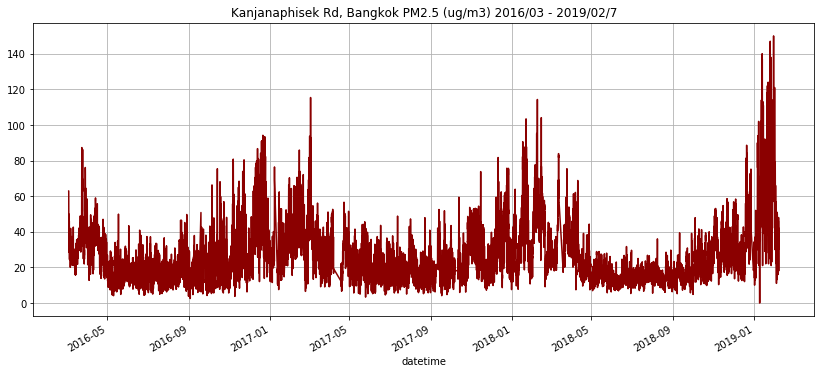

In [3]:
df = pd.read_csv('kanjanaphisek_bangkok_pm25.csv')
df.rename(columns={'UTC Hour':'Hour'}, inplace=True)
df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']]) + pd.Timedelta(hours=7) # UTC to Bangkok time
df.index = df['datetime']
df.Hour = df.index.hour # UTC hour to UTC+7
df.drop(columns=['PM10_mask','Retrospective','datetime'],inplace=True)
df['PM2.5'].plot(figsize=(14,6),title="Kanjanaphisek Rd, Bangkok PM2.5 (ug/m3) 2016/03 - 2019/02/7", color='darkred', grid=True)
df.shape

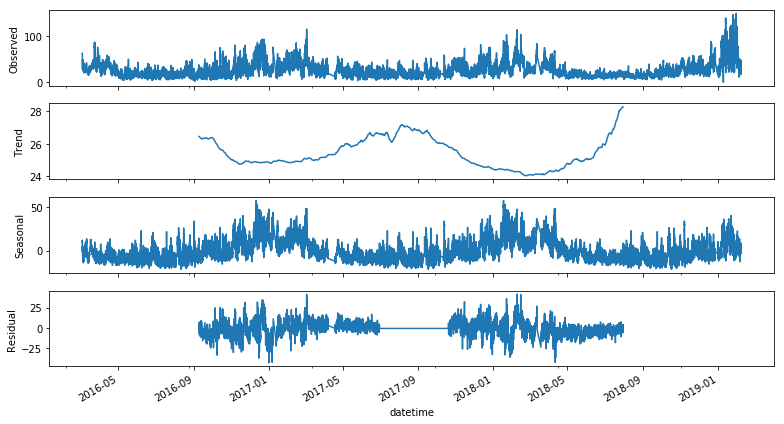

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 11, 6
result = seasonal_decompose(df['PM2.5'], model='addtive', freq=365*24)
fig = result.plot()
plt.show()

In [5]:
# Date features
df['dayofweek'] = df.index.dayofweek 
df['dayofyear'] = df.index.dayofyear
df['weekofyear'] = df.index.weekofyear
df['quarter'] = df.index.quarter
#df['Last24hrs_mean'] = df['PM2.5'].rolling(24).mean().shift(24)
# add holiday?

df.nlargest(5, 'PM2.5') # top 5 highest pm2.5

,Year,Month,Day,Hour,PM2.5,dayofweek,dayofyear,weekofyear,quarter
datetime,,,,,,,,,
2019-01-30 15:00:00,2019,1,30,15,150.0,2,30,5,1
2019-01-25 14:00:00,2019,1,25,14,147.0,4,25,4,1
2019-01-30 14:00:00,2019,1,30,14,145.0,2,30,5,1
2019-01-25 15:00:00,2019,1,25,15,142.0,4,25,4,1
2019-01-13 09:00:00,2019,1,13,9,140.0,6,13,2,1


In [6]:
df.nsmallest(5, 'PM2.5')

,Year,Month,Day,Hour,PM2.5,dayofweek,dayofyear,weekofyear,quarter
datetime,,,,,,,,,
2019-01-09 08:00:00,2019,1,9,8,0.0,2,9,2,1
2019-01-09 09:00:00,2019,1,9,9,0.0,2,9,2,1
2019-01-09 10:00:00,2019,1,9,10,0.0,2,9,2,1
2019-01-09 11:00:00,2019,1,9,11,0.0,2,9,2,1
2019-01-09 12:00:00,2019,1,9,12,0.0,2,9,2,1


In [7]:
## Lag data (previous hours)
def add_Lag(df, lags):
    for i in lags:
        df[f'lag_{i}'] = df['PM2.5'].shift(i)
    return df
#df = add_Lag(df, [1]) # [24,48,72,96,120,144,168] , range(1,25)

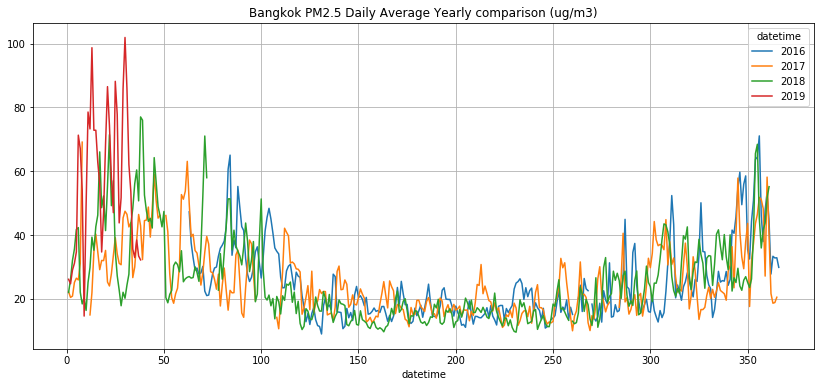

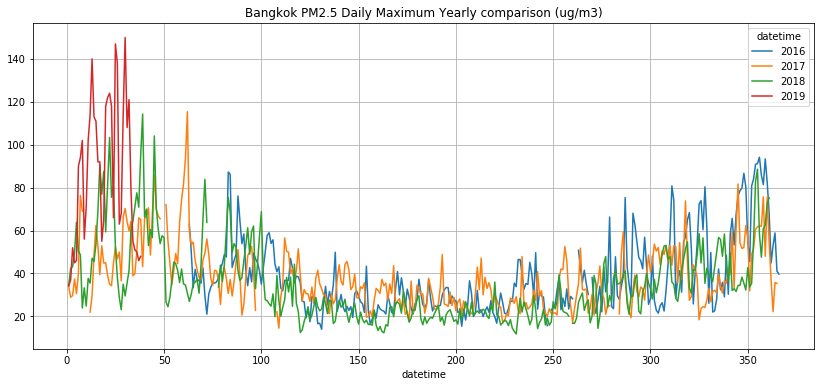

In [8]:
pv = pd.pivot_table(df, index=df.index.dayofyear, columns=df.index.year,
                    values='PM2.5', aggfunc='mean')
pv.plot(title="Bangkok PM2.5 Daily Average Yearly comparison (ug/m3)",figsize=(14,6), grid=True)

pv2 = pd.pivot_table(df, index=df.index.dayofyear, columns=df.index.year,
                    values='PM2.5', aggfunc='max')
pv2.plot(title="Bangkok PM2.5 Daily Maximum Yearly comparison (ug/m3)",figsize=(14,6), grid=True)

Text(0.5, 15.0, 'dayofweek (Mon=0, Sun=6)')

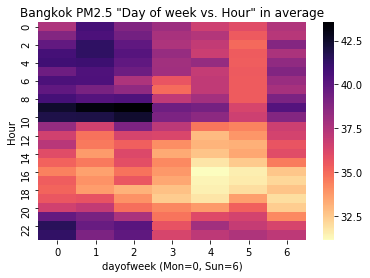

In [9]:
peak_months = df.loc[(df['Month'] == 12) | (df['Month'] <= 4)]
fig, ax = plt.subplots(figsize=(6,4)) 
hrvsday = peak_months.pivot_table(values='PM2.5',index='Hour',columns='dayofweek',aggfunc='mean')
ax.set_title('Bangkok PM2.5 "Day of week vs. Hour" in average')
sns.heatmap(hrvsday,cmap='magma_r', ax=ax) #  Monday=0, Sunday=6
ax.set_xlabel('dayofweek (Mon=0, Sun=6)')

In [10]:
# weather features
weather = pd.read_csv('patumwan_weather.csv', error_bad_lines=False, parse_dates=[0], index_col=[0])
weather = weather.iloc[:,:14] # drop unused col
weather = weather.drop(columns=['windchill'])
weather = pd.get_dummies(weather, prefix=['wind_dir']) # wind direction string to catagory columns
weather.dtypes

temperature         float64
dewpoint            float64
humidity            float64
wind_speed          float64
wind_gust_speed     float64
wind_dir_degrees    float64
pressure            float64
heatindex           float64
precip              float64
precip_rate         float64
precip_1hr          float64
precip_today        float64
wind_dir_ENE          uint8
wind_dir_ESE          uint8
wind_dir_East         uint8
wind_dir_NE           uint8
wind_dir_NNE          uint8
wind_dir_NNW          uint8
wind_dir_NW           uint8
wind_dir_North        uint8
wind_dir_SE           uint8
wind_dir_SSE          uint8
wind_dir_SSW          uint8
wind_dir_SW           uint8
wind_dir_South        uint8
wind_dir_WNW          uint8
wind_dir_WSW          uint8
wind_dir_West         uint8
dtype: object

In [11]:
# average multiple row in 1 hour to 1 row 1 hour, set as index
weather_dt = pd.to_datetime(weather.index)
weather_hrly = weather.groupby([weather_dt.date, weather_dt.hour]).mean()
weather_hrly = weather_hrly.reset_index()
weather_hrly['level_0'] = weather_hrly['level_0'].apply(lambda x: x.strftime('%Y-%m-%d'))
weather_hrly['date'] = weather_hrly['date'].apply(lambda x: '{0:0>2}'.format(x))
weather_hrly.index = pd.to_datetime(weather_hrly['level_0'] + ' ' + weather_hrly['date'].apply(str), format='%Y-%m-%d %H')
weather_hrly = weather_hrly.drop(columns=['level_0','date'])
weather_hrly = weather_hrly.fillna(weather_hrly.mean()) # fill nan with mean of column
weather_hrly.head(5)

,temperature,dewpoint,humidity,wind_speed,wind_gust_speed,wind_dir_degrees,pressure,heatindex,precip,precip_rate,...,wind_dir_NW,wind_dir_North,wind_dir_SE,wind_dir_SSE,wind_dir_SSW,wind_dir_SW,wind_dir_South,wind_dir_WNW,wind_dir_WSW,wind_dir_West
2016-03-02 17:00:00,28.000000,20.000,61.750000,1.2,2.8,117.0,1011.250,29.625000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-02 18:00:00,27.566667,20.000,63.333333,0.0,0.0,117.0,1010.500,29.166667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-02 19:00:00,27.250000,19.850,64.000000,0.0,0.0,117.0,1010.000,28.750000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-02 20:00:00,27.200000,19.850,64.250000,0.0,0.0,117.0,1009.700,28.650000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-02 21:00:00,26.850000,20.975,70.000000,0.8,3.6,115.0,1009.925,28.666667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
## merge pm2.5 with weather
df_merged = pd.concat([df, weather_hrly], axis=1, join_axes=[df.index])
df_merged.columns.values
df_merged.shape

(23814, 37)

PM2.5             1.000000
pressure          0.389653
Year              0.179170
wind_dir_NE       0.166434
wind_dir_NNE      0.143421
wind_dir_ENE      0.134398
wind_dir_North    0.109724
wind_dir_NNW      0.102003
wind_dir_NW       0.096547
wind_dir_SE       0.059809
Name: PM2.5, dtype: float64
dewpoint           -0.384010
humidity           -0.282944
wind_dir_WSW       -0.219658
Month              -0.210331
quarter            -0.209256
dayofyear          -0.206803
weekofyear         -0.205344
wind_speed         -0.177983
wind_dir_degrees   -0.162586
heatindex          -0.161069
Name: PM2.5, dtype: float64


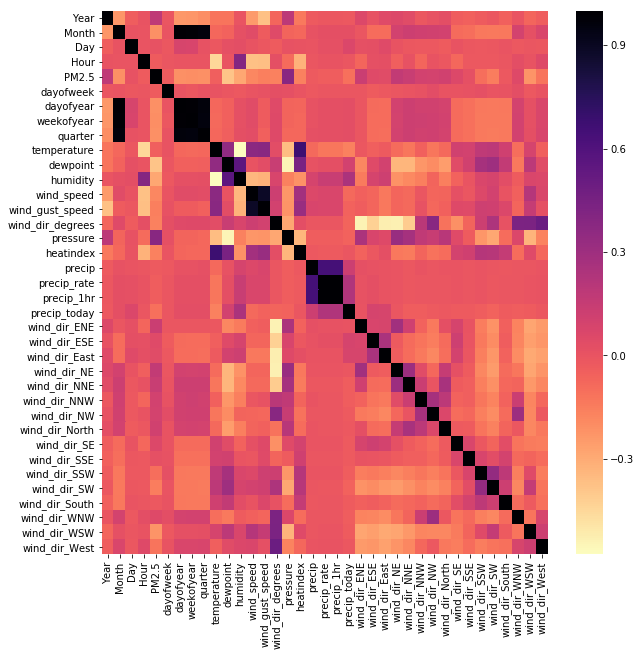

In [13]:
# Linear correlation
df_test = df_merged.drop(df.filter(regex='lag').columns, axis=1)

# calculate the correlation matrix
corr = df_test.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, cmap='magma_r',xticklabels=corr.columns,yticklabels=corr.columns, ax=ax)

print(corr['PM2.5'].sort_values(ascending=False)[:10])
print(corr['PM2.5'].sort_values(ascending=True)[:10])

In [14]:
df_merged.dayofweek = df_merged.dayofweek.apply(str)
df_merged = pd.get_dummies(df_merged, prefix=['dayofweek'])

In [15]:
train_percent = 0.7
train = df_merged.iloc[:int(len(df_merged)*train_percent)]
test = df_merged.iloc[int(len(df_merged)*train_percent):]
X_train = train.drop(columns=['PM2.5'])
X_test = test.drop(columns=['PM2.5'])
y_train = train['PM2.5']
y_test = test['PM2.5']

In [16]:
y_test[y_test.isnull()]

Series([], Name: PM2.5, dtype: float64)

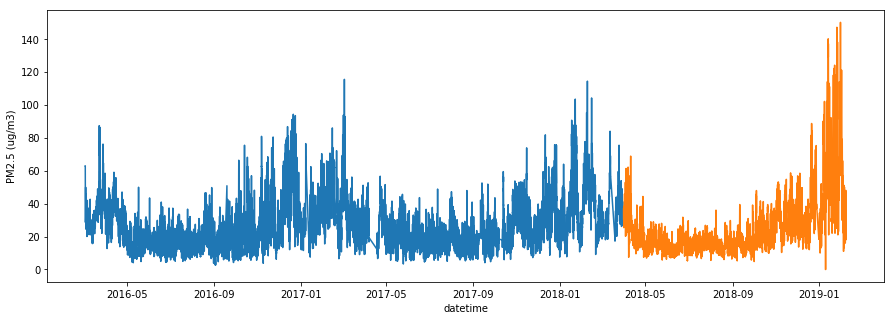

In [17]:
plt.figure(figsize=(15,5))
plt.xlabel('datetime')
plt.ylabel('PM2.5 (ug/m3)')
plt.plot(y_train.index, y_train)
plt.plot(y_test.index, y_test)
plt.show()

In [22]:
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

reg=SVR(gamma='sclae', C=1.0, epsilon=0.2)
#reg.fit(X_train, y_train)
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50,verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

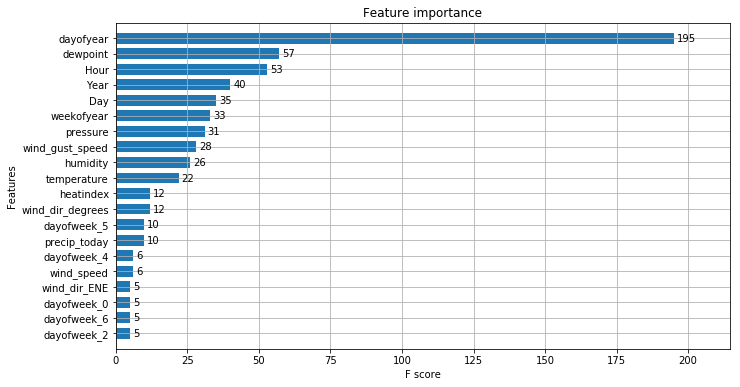

In [23]:
xgb.plot_importance(reg, height=0.7, max_num_features=20)

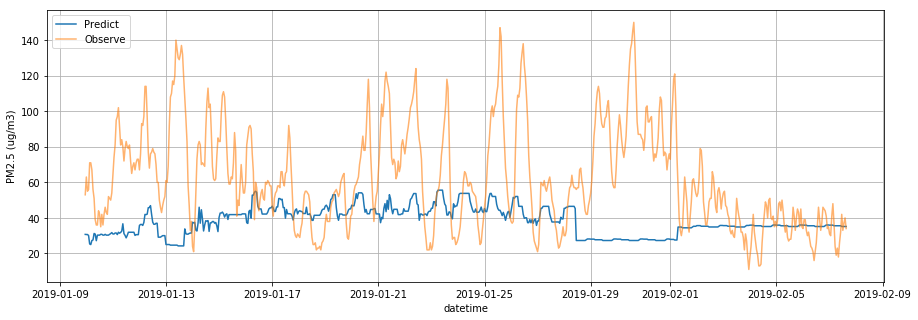

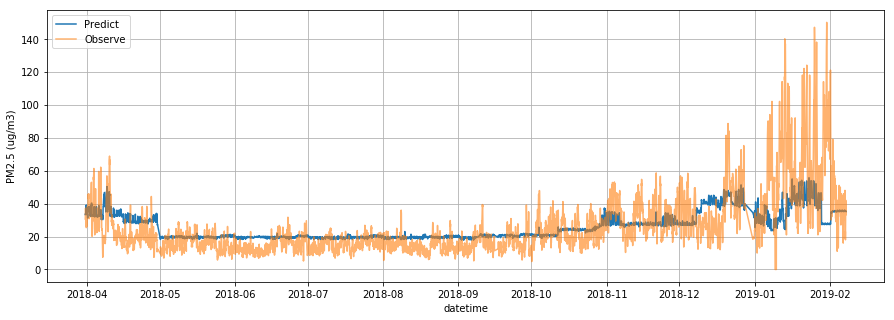

In [24]:
X_test_pred = reg.predict(X_test)

# Plot test data vs. prediction data
plt.figure(figsize=(15,5))
plt.xlabel('datetime')
plt.ylabel('PM2.5 (ug/m3)')
selectdate = 269*24
plt.plot(y_test.index[selectdate:], X_test_pred[selectdate:], label='Predict')
plt.plot(y_test.index[selectdate:], y_test[selectdate:], alpha=0.6, label='Observe')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
plt.xlabel('datetime')
plt.ylabel('PM2.5 (ug/m3)')
plt.plot(y_test.index, X_test_pred, label='Predict')
plt.plot(y_test.index, y_test, alpha=0.6, label='Observe')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [25]:
# Check accuracy
from sklearn.metrics import r2_score
print("Model accuracy: MSE/R-square:")
print(mean_squared_error(y_test, X_test_pred), r2_score(y_test, X_test_pred))
print()

## Use mean-value to predict
print("Mean-value model accuracy: MSE/R-square:")
mean_value = np.mean(y_test)
print(mean_squared_error(y_test, np.ones(len(y_test))*mean_value), r2_score(y_test, np.ones(len(y_test))))

Model accuracy: MSE/R-square:
235.3456310486517 0.33806346312612423

Mean-value model accuracy: MSE/R-square:
355.54107975383454 -1.7106219203529207
